In [6]:
%matplotlib inline
%load_ext Cython

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cython
from pathlib import Path
from os.path import join
from IPython.display import display_markdown
import glob
sns.set()
sns.set_palette('colorblind')
from tqdm import tqdm

import platform

if platform.system() == 'Darwin':
    %config InlineBackend.figure_format = 'retina'


The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [7]:
def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(path + '.gz', *args, **kwargs)
    except: 
        return pd.read_csv(path, *args, **kwargs)

In [26]:
run = 0
path = "/home/pecoffet/remotedata/bm-nvar-tp-2019-01-10-1712/**/rep00/"
logs = []
for curpath in sorted(glob.iglob(path, recursive=True)):
    analyse_file = sorted(glob.glob(curpath + 'analysis_log_*'), reverse=True)[0]
    print(analyse_file)
    log = read_csvx(analyse_file, delimiter="\t")
    log['run'] = run
    log['onOpp'] = (log['oppId'] == 0)
    res = log.groupby(['oppNb', 'oppCoop'], as_index=False).mean()
    res['run'] = run
    logs.append(res)
    run += 1
    if run == 10:
        break
log = pd.concat(logs)

/home/pecoffet/remotedata/bm-nvar-tp-2019-01-10-1712/canonical_bm_tp/run_01/rep00/analysis_log_599.txt.gz
/home/pecoffet/remotedata/bm-nvar-tp-2019-01-10-1712/canonical_bm_tp/run_02/rep00/analysis_log_599.txt.gz
/home/pecoffet/remotedata/bm-nvar-tp-2019-01-10-1712/canonical_bm_tp/run_03/rep00/analysis_log_599.txt.gz
/home/pecoffet/remotedata/bm-nvar-tp-2019-01-10-1712/canonical_bm_tp/run_04/rep00/analysis_log_499.txt.gz
/home/pecoffet/remotedata/bm-nvar-tp-2019-01-10-1712/canonical_bm_tp/run_05/rep00/analysis_log_499.txt.gz
/home/pecoffet/remotedata/bm-nvar-tp-2019-01-10-1712/canonical_bm_tp/run_06/rep00/analysis_log_499.txt.gz
/home/pecoffet/remotedata/bm-nvar-tp-2019-01-10-1712/canonical_bm_tp/run_07/rep00/analysis_log_599.txt.gz
/home/pecoffet/remotedata/bm-nvar-tp-2019-01-10-1712/canonical_bm_tp/run_08/rep00/analysis_log_899.txt.gz
/home/pecoffet/remotedata/bm-nvar-tp-2019-01-10-1712/canonical_bm_tp/run_09/rep00/analysis_log_499.txt.gz
/home/pecoffet/remotedata/bm-nvar-tp-2019-01-1

In [27]:
log

,oppNb,oppCoop,ind,rep,it,oppId,ownCoop,spite,run,onOpp
0,0,0,49.50165,1.000033,49.50165,1.780059,1.850549,0.0,0,0.282043
1,0,1,49.50000,1.000000,49.50000,1.755233,1.851268,0.0,0,0.285967
2,0,2,49.50000,1.000000,49.50000,1.830067,1.799339,0.0,0,0.254900
3,0,3,49.50000,1.000000,49.50000,1.795467,1.802018,0.0,0,0.287633
4,0,4,49.50000,1.000000,49.50000,1.763833,1.827551,0.0,0,0.281900
5,0,5,49.50000,1.000000,49.50000,1.833933,1.791720,0.0,0,0.271767
6,0,6,49.50000,1.000000,49.50000,1.852667,1.790122,0.0,0,0.261733
7,0,7,49.50000,1.000000,49.50000,1.801300,1.789916,0.0,0,0.282133
8,0,8,49.50000,1.000000,49.50000,1.810367,1.830106,0.0,0,0.290767
9,0,9,49.50000,1.000000,49.50000,1.836200,1.809767,0.0,0,0.277633


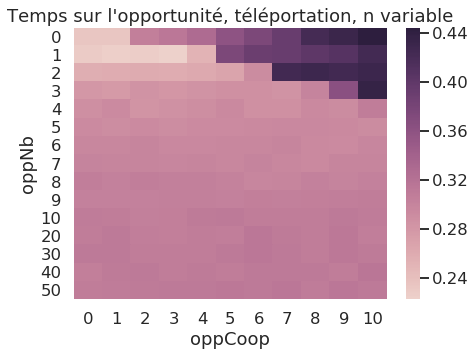

In [33]:
sns.set_context('talk')
heatmap = pd.pivot_table(data=log, values='onOpp', index=['oppNb'], columns=['oppCoop'], aggfunc=np.mean)
plt.figure(figsize=(7, 5))
plt.title('Temps sur l\'opportunité, téléportation, n variable')
sns.heatmap(heatmap, cmap=sns.cubehelix_palette(as_cmap=True))

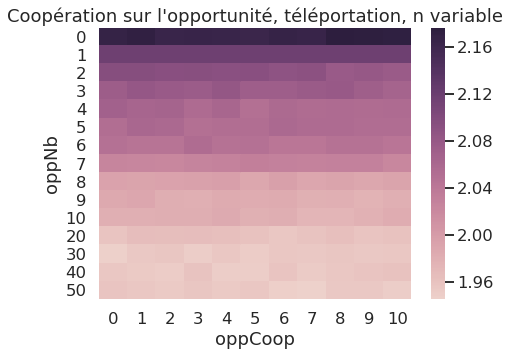

In [32]:
sns.set_context('talk')
heatmap = pd.pivot_table(data=log, values='ownCoop', index=['oppNb'], columns=['oppCoop'], aggfunc=np.mean)
plt.figure(figsize=(7, 5))
plt.title('Coopération sur l\'opportunité, téléportation, n variable')
sns.heatmap(heatmap, cmap=sns.cubehelix_palette(as_cmap=True))

log

In [35]:
run = 0
path = "/home/pecoffet/remotedata/bm-nvar-tp-2019-01-10-1712/**/run_09/rep00/"
logs = []
for curpath in sorted(glob.iglob(path, recursive=True)):
    analyse_file = sorted(glob.glob(curpath + 'analysis_log_*'), reverse=True)[0]
    print(analyse_file)
    log = read_csvx(analyse_file, delimiter="\t")
    log['run'] = run
    log['onOpp'] = (log['oppId'] == 0)
    res = log.groupby(['oppNb', 'oppCoop'], as_index=False).mean()
    res['run'] = run
    logs.append(res)
    run += 1
log2 = pd.concat(logs)

/home/pecoffet/remotedata/bm-nvar-tp-2019-01-10-1712/canonical_bm_tp/run_09/rep00/analysis_log_499.txt.gz


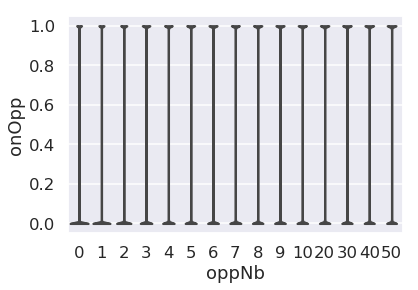

In [36]:
sns.violinplot(data=log.query('oppCoop == 3'), x='oppNb', y='onOpp', cut=0, bw=0.01, inner=None)

Text(0.5,1,'% de temps passé en moyenne par tous les individus avec une coopération = 3')

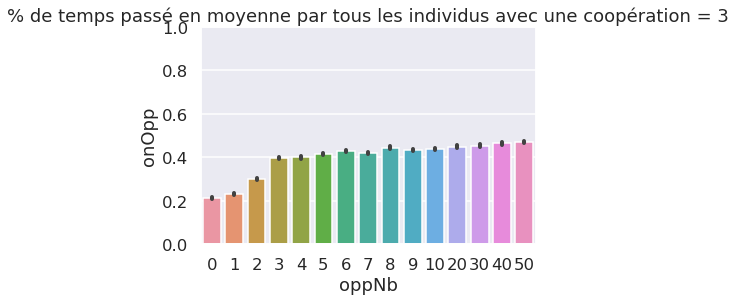

In [40]:
oppCoop = 3
sns.barplot(data=log.query(f'oppCoop == {oppCoop}'), x='oppNb', y='onOpp')
plt.ylim(0, 1)
plt.title(f'% de temps passé en moyenne par tous les individus avec une coopération = {oppCoop}')

Text(0.5,1,'% de temps passé en moyenne par tous les individus avec une coopération = 10')

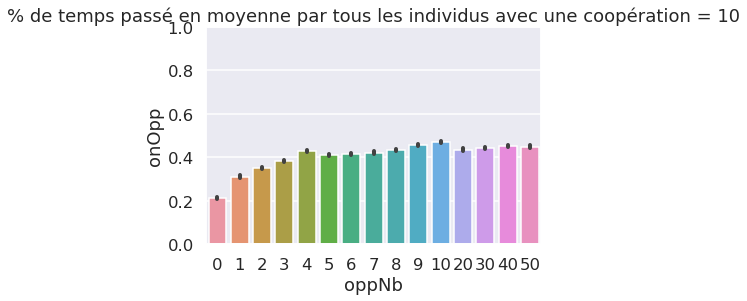

In [42]:
oppCoop = 10
sns.barplot(data=log.query(f'oppCoop == {oppCoop}'), x='oppNb', y='onOpp')
plt.ylim(0, 1)
plt.title(f'% de temps passé en moyenne par tous les individus avec une coopération = {oppCoop}')